In [71]:
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier


from IPython.display import display, Image


import warnings
warnings.filterwarnings('ignore')

<h1>Предсказание коэффициент восстановления золота из золотосодержащей руды

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

 <h2>Описание технологического процесса:

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

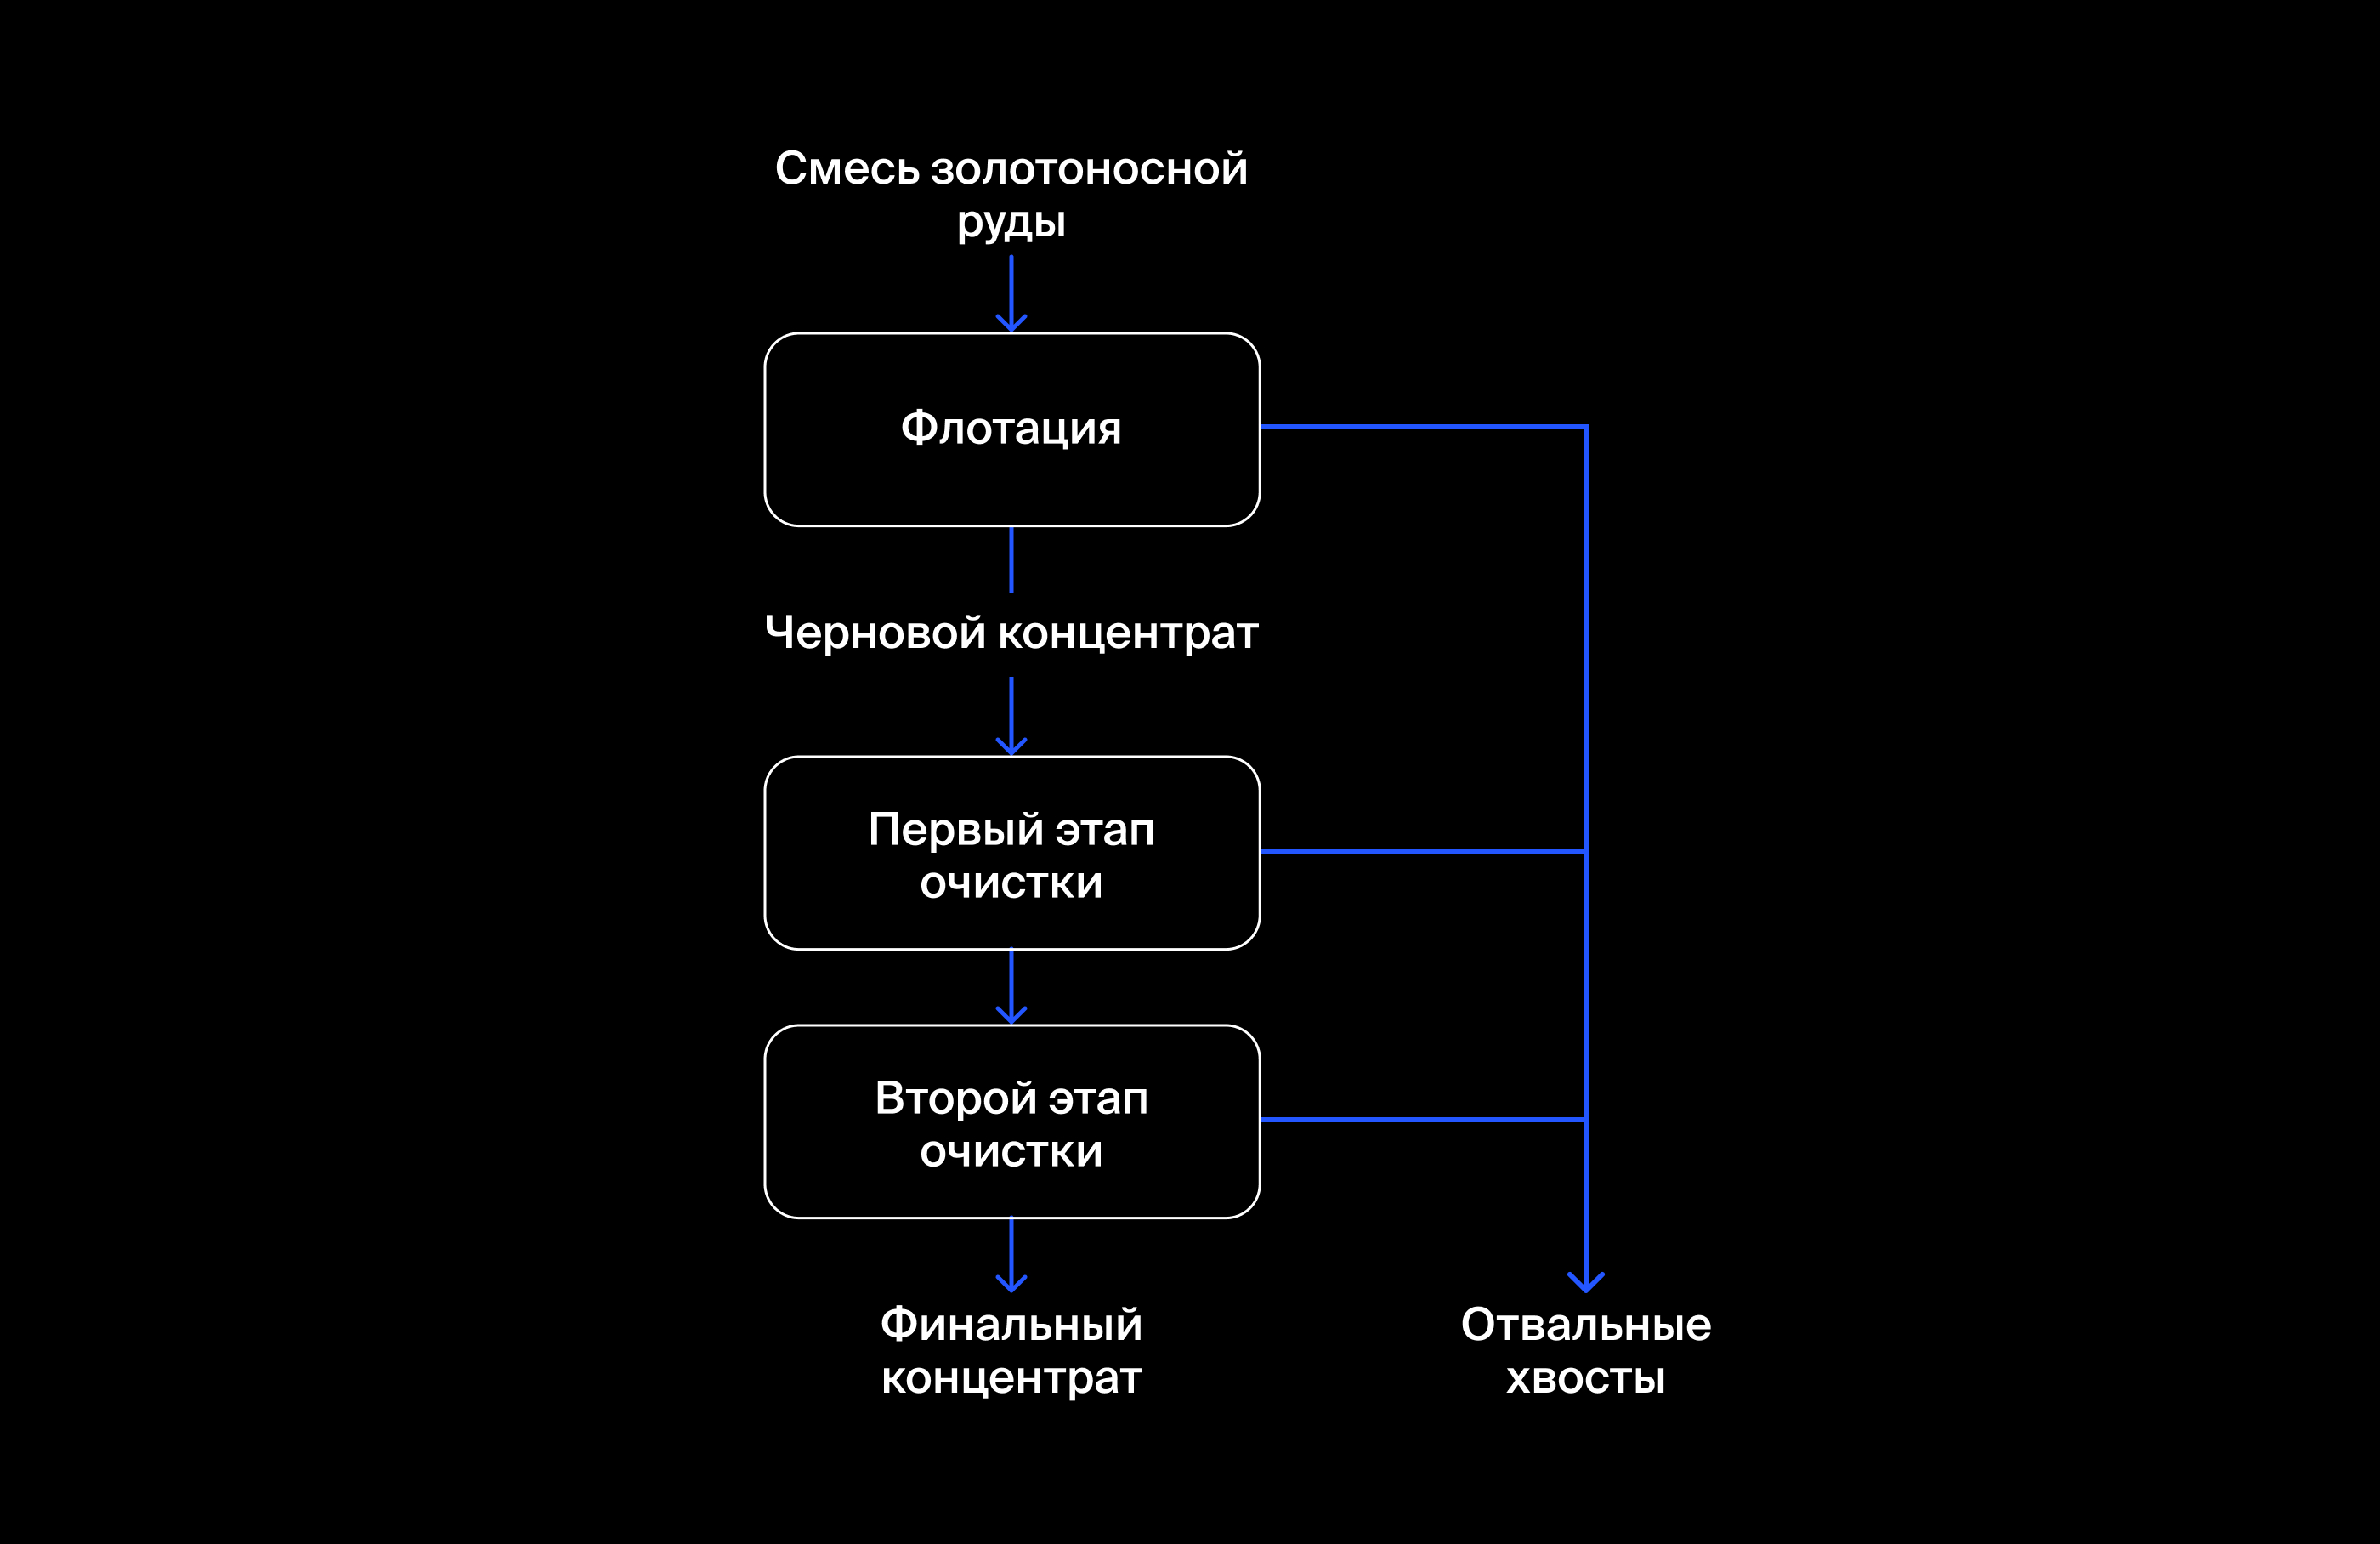

In [2]:
Image("process.jpeg")

Опишем каждую стадию:
- 1. Флотация. Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
- 2. Очистка. Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

###### Данное исследование разделим на несколько частей.
* [Шаг 1. Подготовим данные](#1-step)
* [Шаг 2. Проанализируем данные.](#2-step)
* [Шаг 3. Построим модели.](#3-step)


<a id='1-step'></a>
<h3>Шаг 1. Подготовим данные

#### 1)Считываем данные и смотрим общую информацию

### Данные находятся в трёх файлах:
- gold_recovery_train.csv — обучающая выборка 
- gold_recovery_test.csv — тестовая выборка
- gold_recovery_full.csv — исходные данные


Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища.


### Описание данных:

##### Технологический процесс:
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


#### Параметры этапов:
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


<h3>Наименование признаков:

#### Наименование признаков должно быть такое:
- [этап].[тип_параметра].[название_параметра]

#### Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики


#### Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

### Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery
- эффективность обогащения финального концентрата final.output.recovery

##### Тренировочная выборка:

In [3]:
df_train = pd.read_csv('gold_recovery_train.csv')
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_train.shape

(16860, 87)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


В данных имеются пропуски

##### Тестовая выборка:

In [7]:
df_test= pd.read_csv('gold_recovery_test.csv')
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
df_test.shape

(5856, 53)

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [10]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


В данных имеются пропуски

##### Полная выборка:

In [11]:
df_full = pd.read_csv('gold_recovery_full.csv')
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [12]:
df_full.shape

(22716, 87)

In [13]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [14]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


В данных имеются пропуски

##### 2) Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между вашими расчётами и значением признака.

Формула для подсчета эффективности обогощения:

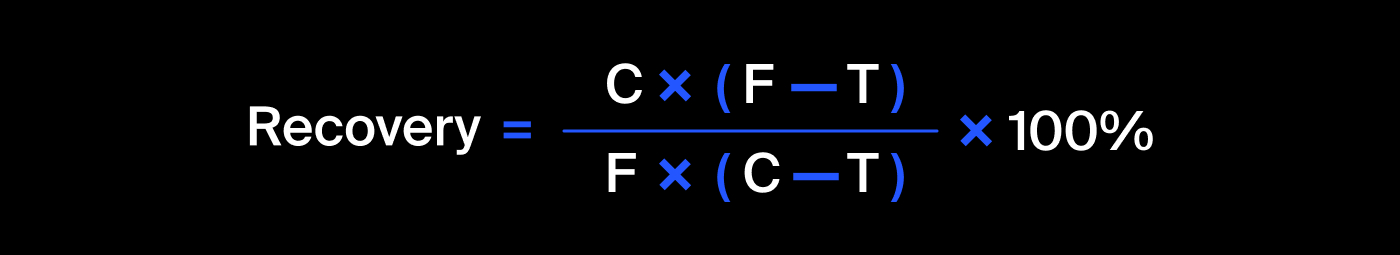

In [15]:
Image("Recovery.jpeg")

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Создадим временный датасет для подсчета, из обучающей выборки для этого удалим все пропуски:

In [16]:
temp_train=df_train.dropna()
C=temp_train['rougher.output.concentrate_au']
F=temp_train['rougher.input.feed_au']
T=temp_train['rougher.output.tail_au']
real_recovery=temp_train['rougher.output.recovery']

In [17]:
recovery=((C*(F-T))/(F*(C-T)))*100

In [18]:
print('MAE между нашими расчётами и значением признака:',mean_absolute_error(real_recovery,recovery))

MAE между нашими расчётами и значением признака: 9.555596961987514e-15


Вывод: 
Эффективность обогащения рассчитана правильно

##### 3) Проанализируйте признаки, недоступные в тестовой выборке:

Заметим сразу, что в тестовый датафрейм нужно добавить целевые признаки, данные возьмем в полном датафрейме:

In [19]:
full_temp=df_full[['date','rougher.output.recovery','final.output.recovery']]
df_test=df_test.merge(full_temp,on='date')
df_test.shape

(5856, 55)

Посмотрим, каких еще столбцов не хватает в тестовом датафрейме:

In [20]:
full_set=set(df_full.columns.to_list())
test_set=set(df_test.columns.to_list())
diff_set=full_set-test_set
diff_set

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

 Понятно, почему их нет в тестовой выборке, эту информацию мы можем получить только во время прохождения процесса. Так как мы не можем использовать данные из будущего для предсказания, нам стоит убрать эти столбцы и из тренировочных данных:

In [21]:
df_train=df_train.drop(list(diff_set),axis=1)
df_train.shape

(16860, 55)

#### 4)Проведите предобработку данных:

Обработаем пропуски:

Строки, где пропущены целевые переменные удалим

В условие сказано:"Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.". Поэтому заменим пропущенные значения предыдущими:

In [22]:
def inputer(df):
    df=df.dropna(subset=['final.output.recovery','rougher.output.recovery'])
    df.fillna(method='bfill',inplace=True)
    return df

In [23]:
df_train=inputer(df_train)
df_train.shape

(14149, 55)

In [24]:
df_test=inputer(df_test)
df_test.shape

(5290, 55)

In [25]:
df_full=inputer(df_full)
df_full.shape

(19439, 87)

In [26]:
print('Пропущенных значений в тренировочных данных:',df_train.isna().sum().sum())

Пропущенных значений в тренировочных данных: 0


In [27]:
print('Пропущенных значений в тестовых данных:',df_test.isna().sum().sum())

Пропущенных значений в тестовых данных: 0


In [28]:
print('Пропущенных значений в полных данных:',df_full.isna().sum().sum())

Пропущенных значений в полных данных: 0


Удалим столбец с датой, так как он не поможет при предсказании:

In [29]:
df_test.drop('date',axis=1,inplace=True)

In [30]:
df_train.drop('date',axis=1,inplace=True)

<a id='2-step'></a>
<h3>Шаг 2. Проанализируем данные.


<h4>1) Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [31]:
AU_list=['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']
AG_list=['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']
PB_list=['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

In [32]:
def distplot_list(df,row,elem):
    j=1
    plt.figure(figsize=(40,10))
    for i in row:
        plt.subplot(1,len(row),j)
        sns.distplot(df[i],label = i)
        plt.title('Distribution plots for: '+elem )
        plt.xlabel(elem)
        plt.legend()
        print()
        j+1
    plt.show()
    display(df[row].describe())

#### Золото:

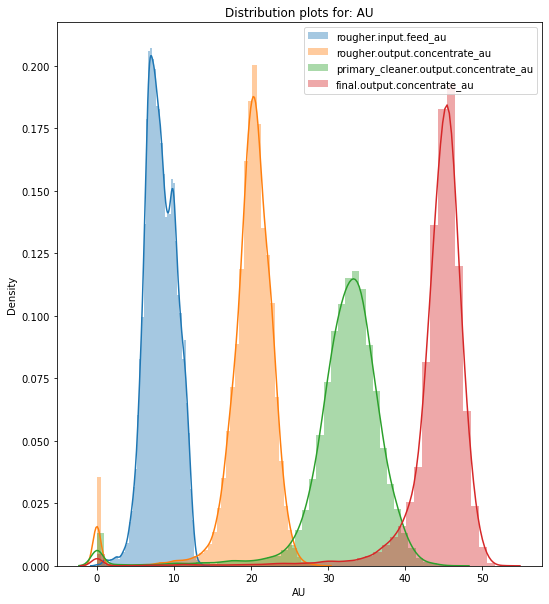

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.266097,19.772000,32.119400,44.076513
std,1.955092,3.753600,5.627611,5.129784
min,0.010000,0.000000,0.000000,0.000000
25%,6.854384,18.802523,30.463140,43.402215
50%,8.125839,20.280214,32.841295,45.011244
75%,9.769917,21.717843,35.048006,46.275313
max,13.731330,28.824507,45.933934,52.756638


In [33]:
distplot_list(df_full, AU_list, 'AU')

 Графики напоминают нормальное распределение(но имеется длинные хвосты слева, и какие то выделяющиеся значения).C каждой последующей стадией концентрация зотола растет, так же на графиках в самом начале можно увидеть нулевые значения,стоит рассмотреть их(возможно это выбросы и стоит удалить)

#### Серебро:

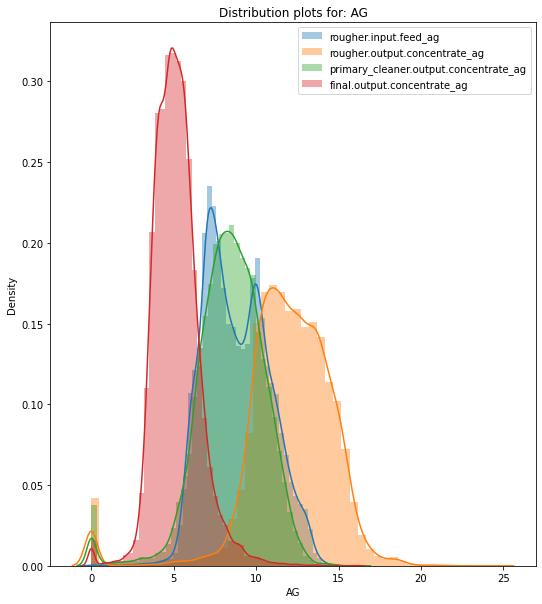

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.794927,11.994759,8.442408,5.168382
std,1.936847,2.733862,2.054465,1.372368
min,0.010000,0.000000,0.000000,0.000000
25%,7.237967,10.628337,7.263288,4.251000
50%,8.593574,12.098115,8.507298,5.066039
75%,10.213771,13.736996,9.809001,5.895401
max,14.596026,24.480271,16.081632,16.001945


In [34]:
distplot_list(df_full, AG_list, 'AG')

  Графики напоминают нормальное распределение(но имеется длинные хвосты слева, и какие то выделяющиеся значения).После флотации концентрация возросла, но после каждого этапа очистки падала . Так же на графиках в самом начале можно увидеть нулевые значения,стоит рассмотреть их(возможно это выбросы и стоит удалить)

#### Cвинец:

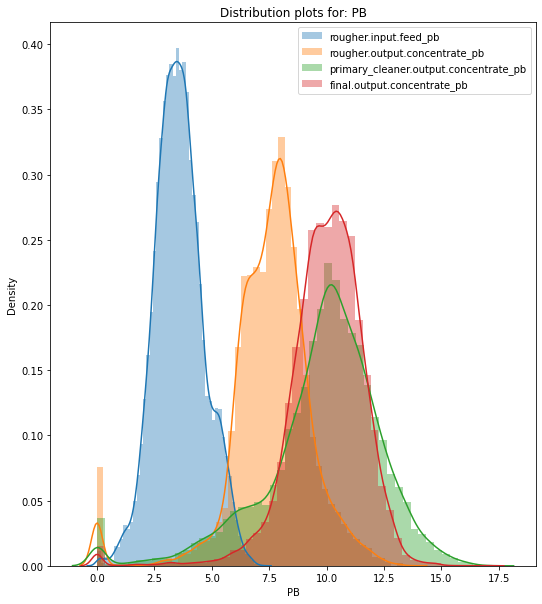

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,3.585850,7.606272,9.810430,9.978817
std,1.062158,1.796757,2.570592,1.669232
min,0.010000,0.000000,0.000000,0.000000
25%,2.872178,6.725987,8.676134,9.137225
50%,3.528235,7.742580,10.140400,10.102264
75%,4.241005,8.565199,11.416298,11.035644
max,7.142594,13.617072,17.081278,17.031899


In [35]:
distplot_list(df_full, PB_list, 'PB')

  Графики напоминают нормальное распределение(но имеется длинные хвосты слева, и какие то выделяющиеся значения).После флотации и первичной обработки концентрация возросла, а после второго этапа очистки концентрация осталась в среднем практический такой же, но все значения стали ближе к среднему(хвосты уменьшились) . Так же на графиках в самом начале можно увидеть нулевые значения,стоит рассмотреть их(возможно это выбросы и стоит удалить)

<h4>2) Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [36]:
def train_test_compare(test,train,col):
    sns.distplot(train[col],label = 'train')
    sns.distplot(test[col],label = 'test')
    plt.legend()
    plt.title('Compare distributions in train and test DataFrame')
    display(pd.DataFrame(zip(train[col].describe(),test[col].describe()),index=train[col].describe().index,columns=['train','test']))
    

,train,test
count,14149.000000,5290.000000
mean,7.322310,7.266339
std,0.614062,0.610219
min,1.080000,5.650000
25%,6.960000,6.890000
50%,7.290000,7.250000
75%,7.700000,7.600000
max,10.470000,15.500000


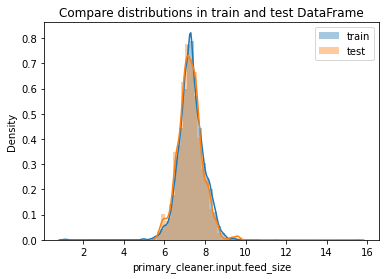

In [37]:
train_test_compare(df_test,df_train,'primary_cleaner.input.feed_size')

В целом кажется, что данные из одного распределения, однако в тестовых данных значения доходят до 15.5, хотя в тренировочных самое большое значение 10.47.(Также если проверить гипотезу о равентсве двух выборок, тест отвергнет нулевую гипотезу и значит распределения отличаются и наши данные поделены не правильно, но в рамках данного проекта я продолжу работу с этим разделением на выборки)

<h4>3) Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Cначала созадим датафрейм с суммами по 3-м веществам:

In [38]:
df_sum=pd.DataFrame()
df_sum['input_sum']=df_full['rougher.input.feed_ag']+df_full['rougher.input.feed_au']+df_full[ 'rougher.input.feed_pb']
df_sum['rougher_sum']=df_full['rougher.output.concentrate_ag']+df_full['rougher.output.concentrate_au']+df_full['rougher.output.concentrate_pb']
df_sum['final_sum']=df_full['final.output.concentrate_ag']+df_full['final.output.concentrate_au']+df_full['final.output.concentrate_pb']
df_sum.head(3)

,input_sum,rougher_sum,final_sum
0,14.871440,38.395653,58.137072
1,14.905729,38.945647,58.699942
2,14.638299,38.649756,58.927421


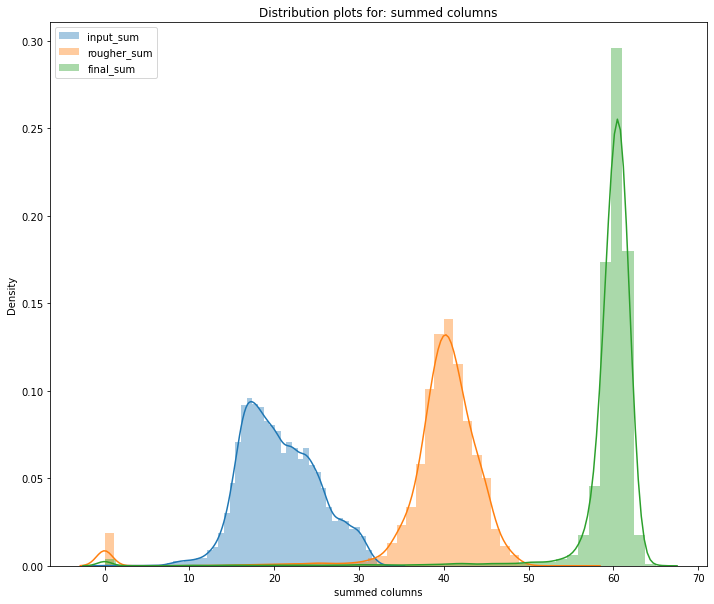

,input_sum,rougher_sum,final_sum
count,19439.000000,19439.000000,19439.000000
mean,20.646875,39.373032,59.223712
std,4.478269,6.863389,6.095166
min,0.030000,0.000000,0.000000
25%,17.252879,38.394639,59.298323
50%,20.141216,40.312648,60.306921
75%,23.797381,42.365102,61.096667
max,33.498784,55.568687,64.968881


In [39]:
distplot_list(df_sum, ['input_sum','rougher_sum','final_sum'],'summed columns')

Значения в начале похожи на анамалии, посмотрим на них:

В сырье:

In [40]:
df_sum[df_sum['input_sum']<1]

,input_sum,rougher_sum,final_sum
18891,0.03,0.03,60.073814
18892,0.03,0.03,60.073814
18893,0.03,0.03,60.073814
18894,0.03,0.03,60.073814
18895,0.03,0.03,47.011298


Это явно ошибка в данных, так как при крактически нулевом значении в начале не может получиться такое высокое в конце, эти значения стоит удалить из тренировочных и тестовых данных

In [41]:
df_train=df_train[(df_train['rougher.input.feed_ag']>0.5)&(df_train['rougher.input.feed_au']>0.5)]
df_train.shape

(14144, 54)

In [42]:
df_test=df_test[(df_test['rougher.input.feed_ag']>0.5)&(df_test['rougher.input.feed_au']>0.5)]
df_test.shape

(5290, 54)

В черновом:

In [43]:
df_sum[df_sum['rougher_sum']<1]

,input_sum,rougher_sum,final_sum
45,17.447608,0.00,61.587298
46,17.938550,0.00,61.520075
47,15.285978,0.00,61.883643
48,13.535634,0.00,59.909941
50,12.341101,0.00,57.756398
...,...,...,...
18891,0.030000,0.03,60.073814
18892,0.030000,0.03,60.073814
18893,0.030000,0.03,60.073814
18894,0.030000,0.03,60.073814


Данные значения также явно являются ошибкой, возможно при загрузке данных, так как изначально была нормальная концентрация, потом стала почти нулевой и снова выросла. В данном случае из тестовых и тренировочных данных ничего удалять не будем, так как значений из промежуточных стадий там нет.

В финальном:

In [44]:
df_sum[df_sum['final_sum']<1]

,input_sum,rougher_sum,final_sum
707,14.940887,34.882253,0.00
1354,18.472933,36.888184,0.00
1355,17.766839,36.014549,0.00
1356,16.897702,35.753279,0.00
1357,16.723931,35.445163,0.00
...,...,...,...
17085,30.120803,39.843711,0.00
17565,19.397305,41.632238,0.00
17566,20.238538,43.860927,0.00
17795,15.035640,28.172746,0.00


Данные значения также явно являются ошибкой, возможно при загрузке данных, так как изначально была нормальная концентрация и после флотации она возросла, и в потом стала почти нулевой. Удалим из тестовых и тренировочных данных эти значения

Так как будем удалять по столбцу 'final.output.recovery', потому что в тренировочных и тестовых данных нет остальных столбцов, проверим: во всех ли примерах 'final.output.recovery' равна 0, где финальная сумма равна 0.

In [45]:
temp=df_full[(df_full['final.output.concentrate_pb']==0)&(df_full['final.output.concentrate_ag']==0)&(df_full['final.output.concentrate_au']==0)]
temp[['final.output.recovery']]

,final.output.recovery
707,0.0
1354,0.0
1355,0.0
1356,0.0
1357,0.0
...,...
17084,0.0
17085,0.0
17565,0.0
17566,0.0


Наше предположение верно. Теперь перед удалением проверим есть ли еще столбцы с нулевым значением 'final.output.recovery', кроме тех, что мы уже нашли:

In [46]:
print(df_full[df_full['final.output.recovery']==0].shape[0])
print(temp.shape[0])

98
98


Значения совпадают значит, мы можем удалять значения с нулевым 'final.output.recovery' и так удалим все значения, где финальная сумма равна 0.

In [47]:
df_train=df_train[df_train['final.output.recovery']!=0]
df_train.shape

(14086, 54)

In [48]:
df_test=df_test[df_test['final.output.recovery']!=0]
df_test.shape

(5250, 54)

<a id='3-step'></a>
<h3>Шаг 3. Построим модели.

#### Метрика качества:

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Метрика sMAPE вычисляется так:

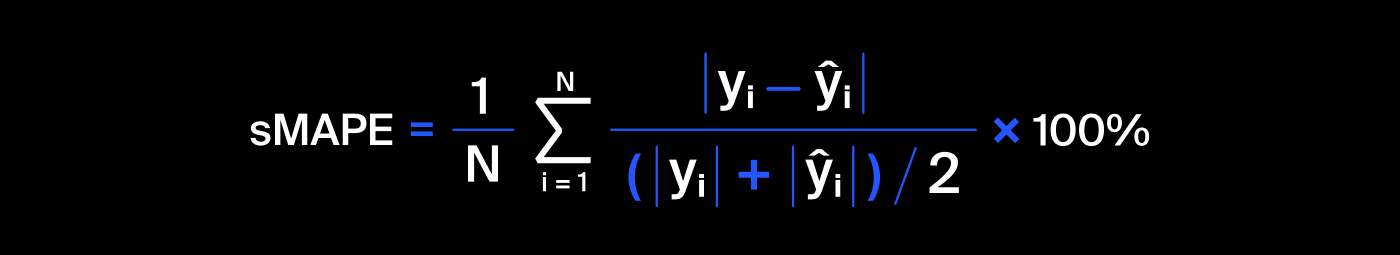

In [49]:
Image("smape.jpeg")

И так как нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.


Итоговая метрика складывается из двух величин:

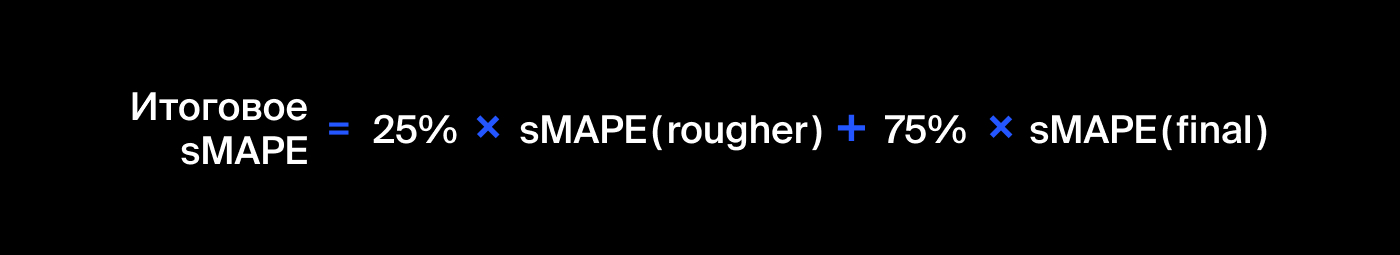

In [50]:
Image("_smape_2.jpeg")

#### 1) Напишим функцию для вычисления  итоговой sMAPE.

In [51]:
def sMAPE(Y_actual,Y_Predicted):
    smape=(np.mean(np.abs((Y_actual - Y_Predicted))*2 / ((np.abs(Y_actual)+np.abs(Y_Predicted)))))*100
    return 0.25*smape['rougher.output.recovery']+0.75*smape['final.output.recovery']

#### 2) Обучим разные модели

Разделим на признаки и таргет:

In [52]:
X_train=df_train.drop(['final.output.recovery','rougher.output.recovery'],axis=1)
y_train=df_train[['rougher.output.recovery','final.output.recovery']]

In [53]:
X_test=df_test.drop(['final.output.recovery','rougher.output.recovery'],axis=1)
y_test=df_test[['rougher.output.recovery','final.output.recovery']]

Cоздадим функцию, которая будет добавлять лучшие значения моделей в таблицу и выводить результаты обучения:

In [54]:
models={}
def inf(x,y,clf,mod_name,params,train):
    pred=clf.predict(x)
    print('Модель:', mod_name)
    print('Параметры модели:',params)
    print('Лучшее значение sMape на кросс валидации тренировочных данных:',np.abs(train))
    print('sMAPE на тестовой:',sMAPE(y,pred))
    models[mod_name]={'sMape на тренировочной':np.abs(train),'sMAPE на тестовой':sMAPE(y,pred)}

Так как мы предсказываем сразу 2 целевые переменный воспользуемся: MultiOutputRegressor, чтоб это сделать, так как изначально эти методы могут предсказывать только 1 целевую переменную

#### Обучим Лассо регрессию:

In [58]:
reg_l1= MultiOutputRegressor(Lasso(normalize=True))
parametrs={'estimator__alpha':np.arange(0,2,0.05)}
grid_l1=GridSearchCV(reg_l1,parametrs,cv=3,scoring=make_scorer(sMAPE,greater_is_better = False))
grid_l1.fit(X_train,y_train)
best_reg_l1=grid_l1.best_estimator_

In [59]:
inf(X_test,y_test,best_reg_l1,'Lasso regression',grid_l1.best_params_,grid_l1.best_score_)

Модель: Lasso regression
Параметры модели: {'estimator__alpha': 0.05}
Лучшее значение sMape на кросс валидации тренировочных данных: 11.451702834565651
sMAPE на тестовой: 9.053967719410533


#### Обучим Гребневую регрессию:

In [60]:
reg_l2= MultiOutputRegressor(Ridge(normalize=True))
parametrs={'estimator__alpha':np.arange(0,2,0.05)}
grid_l2=GridSearchCV(reg_l2,parametrs,cv=5,scoring=make_scorer(sMAPE,greater_is_better = False))
grid_l2.fit(X_train,y_train)
best_reg_l2=grid_l2.best_estimator_

In [61]:
inf(X_test,y_test,best_reg_l2,'Ridge regression',grid_l2.best_params_,grid_l2.best_score_)

Модель: Ridge regression
Параметры модели: {'estimator__alpha': 0.9500000000000001}
Лучшее значение sMape на кросс валидации тренировочных данных: 9.763083806625882
sMAPE на тестовой: 7.880557153626695


#### Обучим Случаиный лес:

In [62]:
reg_rf=RandomForestRegressor(n_jobs=-1)
parametrs={'n_estimators':range(100,300,100),'min_samples_leaf':range(1,7),'min_samples_split':[7,9,11,13]}
grid_rf=RandomizedSearchCV(reg_rf,parametrs,cv=3,scoring=make_scorer(sMAPE,greater_is_better = False))
grid_rf.fit(X_train,y_train)
best_reg_rf=grid_rf.best_estimator_

In [63]:
inf(X_test,y_test,best_reg_rf,'Random Forest',grid_rf.best_params_,grid_rf.best_score_)

Модель: Random Forest
Параметры модели: {'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 6}
Лучшее значение sMape на кросс валидации тренировочных данных: 11.556303796704961
sMAPE на тестовой: 8.760965534810058


#### Обучим Градиентный бустинг:

In [64]:
reg_gb= MultiOutputRegressor(GradientBoostingRegressor())
parametrs={'estimator__n_estimators':range(50,350,100),'estimator__min_samples_leaf':range(1,5),'estimator__min_samples_split':[2,4,6],'estimator__learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
grid_gb=RandomizedSearchCV(reg_gb,parametrs,cv=3,scoring=make_scorer(sMAPE,greater_is_better = False))
grid_gb.fit(X_train,y_train)
best_reg_gb=grid_gb.best_estimator_

In [65]:
inf(X_test,y_test,best_reg_gb,'Gradient Boosting',grid_gb.best_params_,grid_gb.best_score_)

Модель: Gradient Boosting
Параметры модели: {'estimator__n_estimators': 50, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__learning_rate': 0.01}
Лучшее значение sMape на кросс валидации тренировочных данных: 11.080143625034102
sMAPE на тестовой: 8.669518200997153


<h4>Посмотрим на таблицу наших результатов и узнаем какая модель показала себя лучше всего:

In [66]:
score_table=pd.DataFrame.from_dict(data=models,orient='index').sort_values('sMAPE на тестовой')

In [67]:
score_table

,sMape на тренировочной,sMAPE на тестовой
Ridge regression,9.763084,7.880557
Gradient Boosting,11.080144,8.669518
Random Forest,11.556304,8.760966
Lasso regression,11.451703,9.053968


#### Обучим фиктивную модель :

Обучим регрессор, предсказывающий средние значения, для проверки наших моделей на адекватность:

In [68]:
reg_dum = MultiOutputRegressor(DummyRegressor(strategy="mean"))
reg_dum.fit(X_train,y_train)
print('sMAPE фиктивной модели: ',sMAPE(y_test,reg_dum.predict(X_test)))

sMAPE фиктивной модели:  9.053967719410533


 #### Вывод: лучше всего с данной задачей справляется Гребневая регрессия, показав final_sMAPE: 7.880557 , и она также показывает себя лучше чем простой DummyRegressor: 9.053968